## Data: Set up and Validation

In [1]:
# Standard
import itertools
from dateutil.relativedelta import relativedelta
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Network Analysis 
from src.backboning import (
    read,
    thresholding,
    disparity_filter,
    noise_corrected
)
from networkx.algorithms.community.quality import modularity
import community as community_louvain
import networkx as nx

# Local Modules
from src import info_theory
from src import preprocess
from src import kraskov_jidt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Helper functions
FILEPATH = 'results/function_values_.xlsx'

# ==== Functions for populating matrices ====
def populate_pairwise_adjacency_matrix(df, asset_list, function, *args):
    """
    Populates a symmetric adjacency matrix for pairwise relationships between assets.
    Applies the specified metric_func to each unique asset pair.
    """
    adjacency_matrix = pd.DataFrame(index=asset_list, columns=asset_list)
    for asset_1 in asset_list:
        for asset_2 in asset_list:
            if pd.isna(adjacency_matrix.at[asset_1, asset_2]):
                if function in [info_theory.MI, kraskov_jidt.calc_mi_kraskov]:
                    value = info_theory.surrogate(function, df, asset_1, asset_2) if asset_1 != asset_2 else 0
                elif function in [info_theory.second_gradient_of_Oinfo]:
                    value = function(df, asset_1, asset_2, args) if asset_1 != asset_2 else 0
                else:
                    value = 0
                adjacency_matrix.at[asset_1, asset_2] = value
                adjacency_matrix.at[asset_2, asset_1] = value
    return adjacency_matrix.astype(float)

def get_dates(df, window_size_years, rolling_size_years):
    """
    Generates a list of start dates for rolling windows over the dataframe index.
    """
    start_date = df.index.min()
    end_date = df.index.max()
    curr_date = start_date

    dates = []
    while curr_date + relativedelta(years=window_size_years) < end_date:
        dates.append(curr_date)
        curr_date += relativedelta(years=rolling_size_years)
    return dates

def populate_date_adjacency_matrix(df, dates, columns, function, window_size_years, *args):
    """
    Populates an adjacency matrix with time windows as rows and asset combinations as columns.
    Applies the specified function to each windowed slice of the data.
    """
    adjacency_matrix = pd.DataFrame(index=dates, columns=columns)
    for curr_date in dates:
        # Slice dataframe for the current time window
        sliced_df = df[(df.index >= curr_date) & (df.index < curr_date + relativedelta(years=window_size_years))]
        if function in [info_theory.Oinfo]:
            for combination in columns:
                adjacency_matrix.at[curr_date, combination] = info_theory.surrogate(function, sliced_df[list(combination)])
        elif function in [info_theory.MI, kraskov_jidt.calc_mi_kraskov]:
            for (first_asset, second_asset) in columns:
                adjacency_matrix.at[curr_date, (first_asset, second_asset)] = info_theory.surrogate(function, sliced_df, first_asset, second_asset)
        elif function == info_theory.gradient_of_Oinfo:
            for asset in columns:
                adjacency_matrix.at[curr_date, asset] = info_theory.surrogate(function, sliced_df, asset, args)
    return adjacency_matrix

# ==== Functions for saving and loading results ====
def format_dict_to_df(result):
    """
    Converts a dictionary with tuple keys into a pandas Series with string keys.
    """
    formatted_result = {"-".join(list(key)): value for key, value in result.items()}
    return pd.Series(formatted_result)

def args_to_sheet_name(df, func, args):
    """
    Generates a unique sheet name based on function, dataframe, and arguments.
    """
    # Accept both function objects and strings
    func_name = func.__name__ if callable(func) else func

    # Check if args is iterable, if not convert it to a list
    def is_iterable(obj):
        try:
            iter(obj)
            return True
        except TypeError:
            return False
    if not is_iterable(args):
        args = [args]
    
    return f"{func_name}_{df.index.min().strftime('%y')}{df.index.max().strftime('%y')}{''.join([str(i)[0] for i in list(df.columns)])}{''.join([str(arg)[0] for arg in args])}"

def load_function_values(sheet_name):
    """
    Loads a DataFrame from an Excel sheet if it exists; otherwise creates the sheet.
    """
    try:
        df = pd.read_excel(FILEPATH, sheet_name=sheet_name, index_col=0, parse_dates=True)
    except:
        workbook = load_workbook(FILEPATH)
        workbook.create_sheet(sheet_name)
        workbook.save(FILEPATH)
        df = None
    return df

def save_function_values(sheet_name, df):
    """
    Saves a DataFrame to an Excel sheet, replacing the sheet if it already exists.
    """
    with pd.ExcelWriter(FILEPATH, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=sheet_name)

def calculate(generate_matrix_func, func, df, *args):
    """
    Loads a precomputed matrix from file if available to prevent recalculation, otherwise computes and saves it.
    Takes in a generate_matrix_func to compute the matrix based on different information theoretical metrics.
    """
    # Compute MI between all tickers
    sheet_name = args_to_sheet_name(df, func, args)

    result = load_function_values(sheet_name)
    if not isinstance(result, pd.DataFrame) or result.empty:
        result = generate_matrix_func(df, *args)
        save_function_values(sheet_name, result)
    return result


### Loading Data and Preprocessing

In [5]:
def load_data(num_bins):
    """
    Load and preprocess asset data from Excel files.
    Steps:
    - Read historical price data for different asset classes.
    - Clean specific data inconsistencies.
    - Compute log returns.
    - Standardize data.
    - Apply PCA and discretize principal components.
    - Discretize standardized returns.

    Parameters:
        num_bins (int): Number of bins for discretizing PCA components.

    Returns:
        standardized_returns_df (pd.DataFrame): Standardized log returns.
        pca_discretized_df (pd.DataFrame): Discretized first PCA component per asset class.
        pca_continuous_df (pd.DataFrame): First PCA component per asset class.
        discretized_returns_df (pd.DataFrame): Discretized version of standardized log returns.
    """
    # List of asset class names matching Excel file names
    asset_classes = [
        'credit', 'equity', 'volatility', 'energy', 'currency', 'real_estate', 'commodity', 'interest', 'metals'
    ]

    # Load and reverse DataFrames (from oldest to newest)
    asset_price_dfs = [
        pd.read_excel(f"data/{asset}_data.xlsx", sheet_name="Price", index_col=0, parse_dates=True)[::-1]
        for asset in asset_classes
    ]

    # Compute log returns for each asset class
    log_return_dfs = [preprocess.compute_log_return(df) for df in asset_price_dfs]

    # Combine log returns across all asset classes into a multi-indexed DataFrame
    combined_log_returns = pd.concat(log_return_dfs, axis=1, keys=asset_classes, join='inner')
    combined_log_returns = combined_log_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # Standardize the log returns
    standardized_returns = StandardScaler().fit_transform(combined_log_returns)
    standardized_returns_df = pd.DataFrame(
        standardized_returns,
        columns=combined_log_returns.columns,
        index=combined_log_returns.index
    )

    # --- PCA helper functions ---

    def compute_first_pca_component(df):
        """Compute the first PCA component for an asset class."""
        pca, components = preprocess.compute_pca(df)
        return components[:, 0]  # First component only

    def compute_discretized_first_pca(df):
        """Compute and discretize the first PCA component using quantile binning."""
        pca, components = preprocess.compute_pca(df)
        first_component = components[:, :1]  # Use only first PC for binning
        return preprocess.bin_data_with_quartiles(first_component, num_bins)

    # Apply PCA and discretize per asset class
    pca_discretized_series = standardized_returns_df.groupby(level=0, axis=1).apply(compute_discretized_first_pca)
    pca_discretized_df = pca_discretized_series.to_frame().T
    pca_discretized_df = pca_discretized_df.explode(pca_discretized_df.columns.to_list()).set_index(standardized_returns_df.index)
    
    # Compute first PCA component per asset class (continuous values)
    pca_continuous_series = standardized_returns_df.groupby(level=0, axis=1).apply(compute_first_pca_component)
    pca_continuous_df = pca_continuous_series.to_frame().T
    pca_continuous_df = pca_continuous_df.explode(pca_continuous_df.columns.to_list()).set_index(standardized_returns_df.index)

    # Discretize standardized returns into bins based on std deviation
    def std_based_discretization(series):
        std_dev = np.std(series)
        bin_edges = std_dev * np.arange(-6, 7)
        return np.digitize(series, bin_edges)

    # Drop asset class level for direct ticker access, then discretize
    flattened_returns_df = standardized_returns_df.droplevel(0, axis=1)
    discretized_returns_df = flattened_returns_df.apply(std_based_discretization)

    # Return all processed dataframes
    return standardized_returns_df, pca_discretized_df, pca_continuous_df, discretized_returns_df


In [6]:
# Configurations (unless otherwise specified)
num_bin = 5
window_size_years = 5
rolling_size_years = 2

# Initialise all required data
standardized_log_return_df, assets_pca_discrete, asset_pca_cont, discretized_log_return_df = load_data(num_bin)

1. Validating that tickers cluster into asset classes

In [9]:
def tickers_graph(standardized_log_return_df, discretized_log_return_df):
    """
    Constructs a mutual information (MI) network from stock tickers and evaluates
    different network backboning methods for their ability to reveal true asset class structure.

    Parameters:
    - standardized_log_return_df (pd.DataFrame): MultiIndex DataFrame of standardized returns.
    - discretized_log_return_df (pd.DataFrame): DataFrame of discretized returns for MI calculation.

    Returns:
    - functions (list): List of backboning methods applied.
    - nvis (list): List of NVI values indicating similarity to true partition.
    """
    
    tickers = list(discretized_log_return_df.columns)

    # --- Step 1: Compute pairwise Mutual Information ---
    mi_adjacency_matrix = pd.DataFrame(index=tickers, columns=tickers)
    for ticker1 in tickers:
        for ticker2 in tickers:
            if pd.isna(mi_adjacency_matrix.at[ticker1, ticker2]):
                mi = info_theory.MI(discretized_log_return_df, ticker1, ticker2) if ticker1 != ticker2 else 0
                mi_adjacency_matrix.at[ticker1, ticker2] = mi
                mi_adjacency_matrix.at[ticker2, ticker1] = mi  # Symmetric

    mi_adjacency_matrix = mi_adjacency_matrix.astype(float)
    original_graph = nx.from_pandas_adjacency(mi_adjacency_matrix)

    # --- Step 2: Define true partition using top-level asset class labels ---
    unique_labels = {name: idx for idx, name in enumerate(standardized_log_return_df.columns.levels[0])}
    true_partition = {ticker: unique_labels[asset] for asset, ticker in standardized_log_return_df.columns}

    # --- Step 3: Convert adjacency matrix to edge list ---
    edge_list = mi_adjacency_matrix.stack().reset_index()
    edge_list.columns = ['src', 'trg', 'weight']
    table, _, _ = read(edge_list, "weight", undirected=True, consider_self_loops=False)

    # --- Step 4: Apply backboning filters ---
    functions = [noise_corrected, disparity_filter]

    nvis = []
    for f in functions:
        # Apply backboning method and threshold top 5% strongest edges
        sparsed_table = f(table, undirected=True)
        backbone = thresholding(sparsed_table, sparsed_table["score"].quantile(0.95))

        # Create graph from filtered edges
        G = nx.from_pandas_edgelist(backbone, source="src", target="trg", edge_attr="nij", create_using=nx.Graph())

        # --- Step 5: Community detection using Louvain ---
        partition = community_louvain.best_partition(G)

        # Assign dummy communities to isolated nodes (not in backbone)
        unassigned_nodes = set(original_graph.nodes()) - set(G.nodes())
        for node in unassigned_nodes:
            partition[node] =  len(partition)

        # Compare communities
        true_communities = [true_partition[ticker] for ticker in original_graph.nodes()]
        detected_communities = [partition[ticker] for ticker in original_graph.nodes()]
        
        modularity_score = community_louvain.modularity(partition, G)
        nvi_score = info_theory.NVI(true_communities, detected_communities)
        nvis.append(nvi_score)

        print(f"{f.__name__}: Modularity = {modularity_score:.4f}, NVI = {nvi_score:.4f}")

        # --- Step 6: Visualization ---
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G, k=0.45)
        nx.draw(
            G,
            pos=pos,
            with_labels=True,
            edge_color="black",
            width=[G[u][v]["nij"] * 5 for u, v in G.edges()]
        )
        plt.title(f"Backbone using {f.__name__}")
        
    return functions, nvis


Calculating NC score...
Calculating DF score...


noise_corrected: Modularity = 0.7396, NVI = 0.3048
disparity_filter: Modularity = 0.7810, NVI = 0.2583


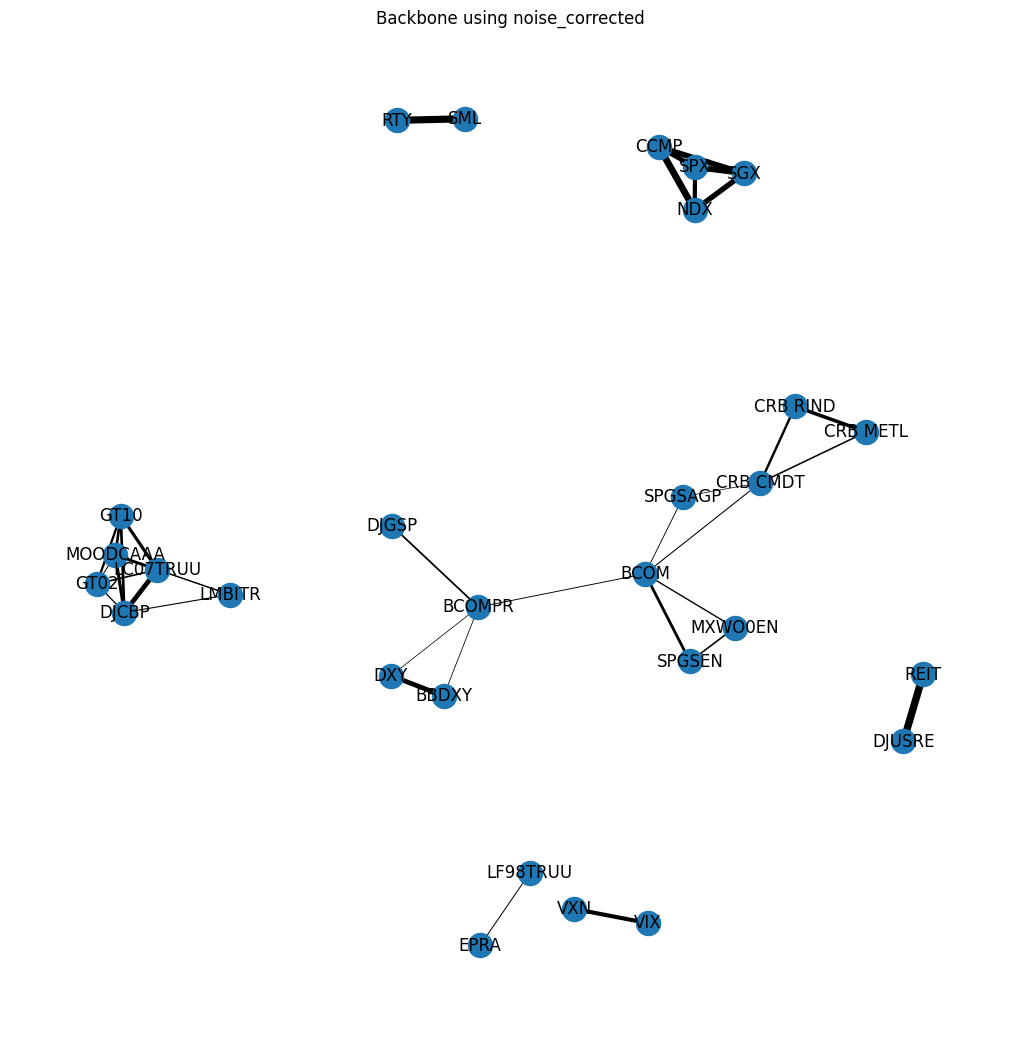

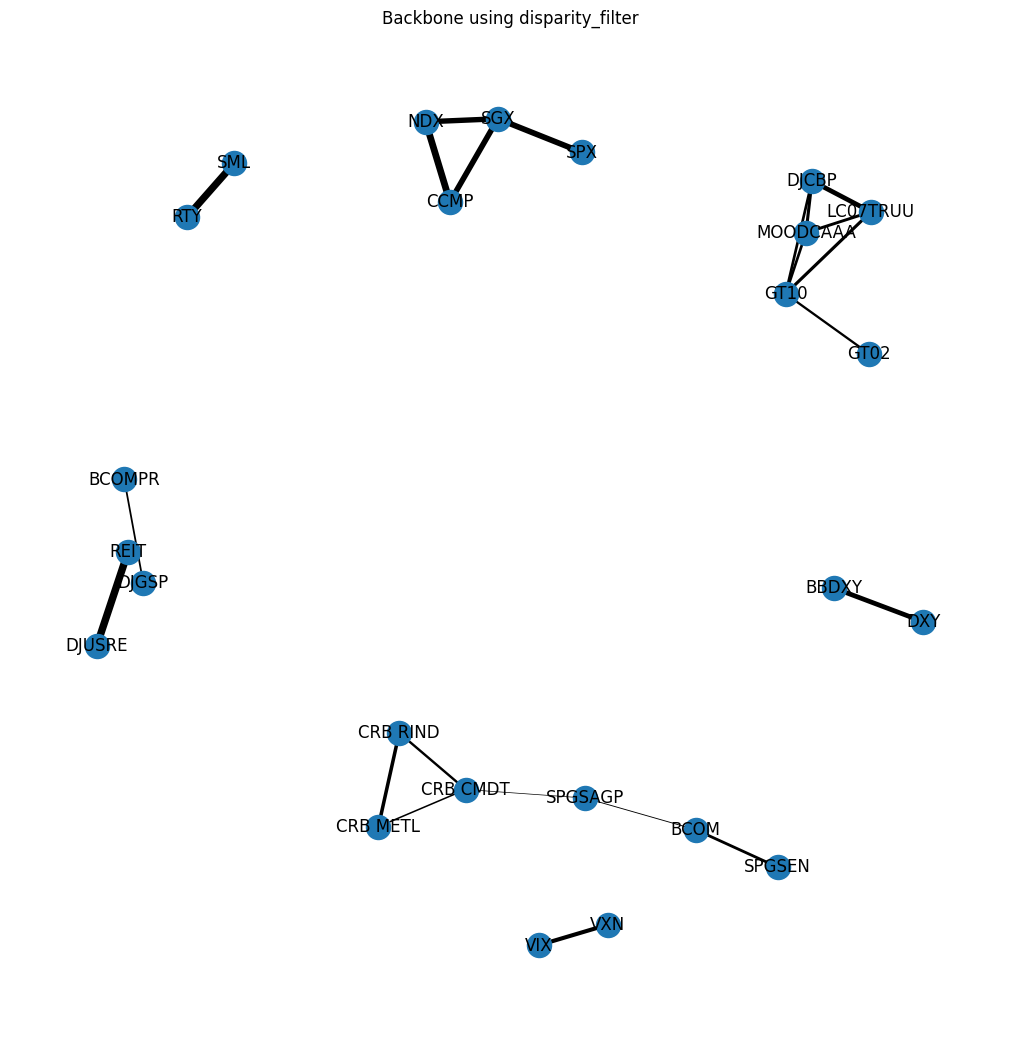

In [10]:
functions, nvis = tickers_graph(standardized_log_return_df, discretized_log_return_df)

In [17]:
def permutation_test_nvi(
    standardized_log_return_df,
    discretized_log_return_df,
    sparsify_func,
    observed_nvi,
    n_permutations=100
):
    """
    Performs a permutation test on the Normalized Variation of Information (NVI)
    to assess whether the observed partition quality is statistically significant
    under randomization of edge weights.

    Parameters:
        standardized_log_return_df (pd.DataFrame): MultiIndex DataFrame with hierarchical asset class info.
        discretized_log_return_df (pd.DataFrame): DataFrame with discretized log returns.
        sparsify_func (callable): A backboning method like noise_corrected or disparity_filter.
        observed_nvi (float): NVI value for the real (non-permuted) graph.
        n_permutations (int): Number of permutations to perform.

    Returns:
        bool: True if observed NVI is significantly lower than the null (p < 0.05), False otherwise.
    """

    # Load precomputed mutual information adjacency matrix
    mi_adjacency_matrix = load_function_values("tickers_mi")
    G = nx.from_pandas_adjacency(mi_adjacency_matrix)

    # Define true partition based on asset class labels
    asset_class_labels = {name: idx for idx, name in enumerate(standardized_log_return_df.columns.levels[0])}
    true_partition_dict = {ticker: asset_class_labels[asset] for asset, ticker in standardized_log_return_df.columns}

    # Load or initialize surrogate (null) NVI values
    surrogate_nvis = load_function_values(f"perm_test_{sparsify_func.__name__}_nvi")
    if surrogate_nvis is None or surrogate_nvis.empty:
        surrogate_nvis = []

        # Extract original edges and weights for permutation
        original_edges = list(G.edges(data='weight'))
        original_weights = [w for _, _, w in original_edges]

        for _ in range(n_permutations):
            # Shuffle weights while keeping the topology fixed
            shuffled_weights = random.sample(original_weights, len(original_weights))
            G_permuted = G.copy()
            for (u, v, _), w_new in zip(original_edges, shuffled_weights):
                G_permuted[u][v]['weight'] = w_new

            # Convert to edge list format required by `read`
            edge_list_df = nx.to_pandas_edgelist(G_permuted).rename(columns={'source': 'src', 'target': 'trg'})
            table, _, _ = read(edge_list_df, "weight", undirected=True, consider_self_loops=False)

            # Apply backboning and thresholding
            backbone_table = sparsify_func(table, undirected=True)
            backbone_filtered = thresholding(backbone_table, backbone_table["score"].quantile(0.95))

            # Build graph from filtered backbone
            backbone_graph = nx.from_pandas_edgelist(
                backbone_filtered,
                source="src", target="trg", edge_attr="nij", create_using=nx.Graph()
            )

            # Perform community detection
            perm_partition_dict = community_louvain.best_partition(backbone_graph)

            # Assign dummy communities for unconnected nodes
            unassigned_nodes = set(G.nodes()) - set(backbone_graph.nodes())
            next_community_id = max(perm_partition_dict.values(), default=0) + 1
            for node in unassigned_nodes:
                perm_partition_dict[node] = next_community_id
                next_community_id += 1

            # Build true and permuted community lists
            true_partition = [true_partition_dict[ticker] for ticker in G.nodes()]
            perm_partition = [perm_partition_dict[ticker] for ticker in G.nodes()]

            # Compute NVI and store
            nvi_score = info_theory.NVI(perm_partition, true_partition)
            surrogate_nvis.append(nvi_score)

            # Save after each iteration for robustness
            save_function_values(f"perm_test_{sparsify_func.__name__}_nvi", pd.Series(surrogate_nvis))

    # Statistical test: observed NVI must be below 5th percentile of null distribution
    significance_threshold = np.percentile(surrogate_nvis, 5)
    return observed_nvi < significance_threshold


In [18]:
for func, nvi in zip(functions, nvis):
    print(f"{func.__name__}: NVI - {nvi}, significant at 5% - {permutation_test_nvi(standardized_log_return_df, discretized_log_return_df, func, nvi, n_permutations=100)}")

noise_corrected: NVI - 0.30475094824232085, significant at 5% - True
disparity_filter: NVI - 0.2582878460906879, significant at 5% - True


2. Choosing the most appropraite bin size to discretise mutual information

In [7]:
def compare_discrete_and_continuous_mi():
    """
    Compares mutual information (MI) values computed using discrete (binned) and continuous estimators
    across different bin sizes. Plots the relationship between discrete and continuous MI for all asset pairs.
    """
    bin_sizes = [i for i in range(4, 8)]  # Range of bin sizes to test for discretization

    # Load continuous PCA-transformed asset data
    _, _, asset_pca_continuous, _ = load_data(1)
    asset_names = asset_pca_continuous.columns.to_list()

    # Generate all unique asset pairs
    asset_pairs = list(itertools.combinations(asset_names, 2))

    # Compute continuous MI for all asset pairs using the Kraskov estimator
    continuous_mi_df = populate_pairwise_adjacency_matrix(asset_pca_continuous, asset_names, kraskov_jidt.calc_mi_kraskov)

    plt.figure(figsize=(10, 10))
    for num_bins in bin_sizes:
        # Load discretized data for the current bin size
        _, asset_pca_discrete, _, _ = load_data(num_bins)

        # Compute discrete MI for all asset pairs
        discrete_mi_df = populate_pairwise_adjacency_matrix(asset_pca_discrete, asset_names, info_theory.MI)

        # Collect MI values for all pairs: (discrete MI, continuous MI)
        mi_pairs = [(discrete_mi_df.loc[i, j], continuous_mi_df.loc[i, j]) for i, j in asset_pairs]

        x_vals, y_vals = zip(*mi_pairs)

        plt.scatter(x_vals, y_vals, label=f"{num_bins} bins")  # Plot for each bin size

    plt.xlabel("Discrete MI")
    plt.ylabel("Continuous MI")
    plt.legend()


./src/kraskov/infodynamics.jar;c:\Users\user\Programming\School\fyp-1\venv\lib\site-packages\org.jpype.jar


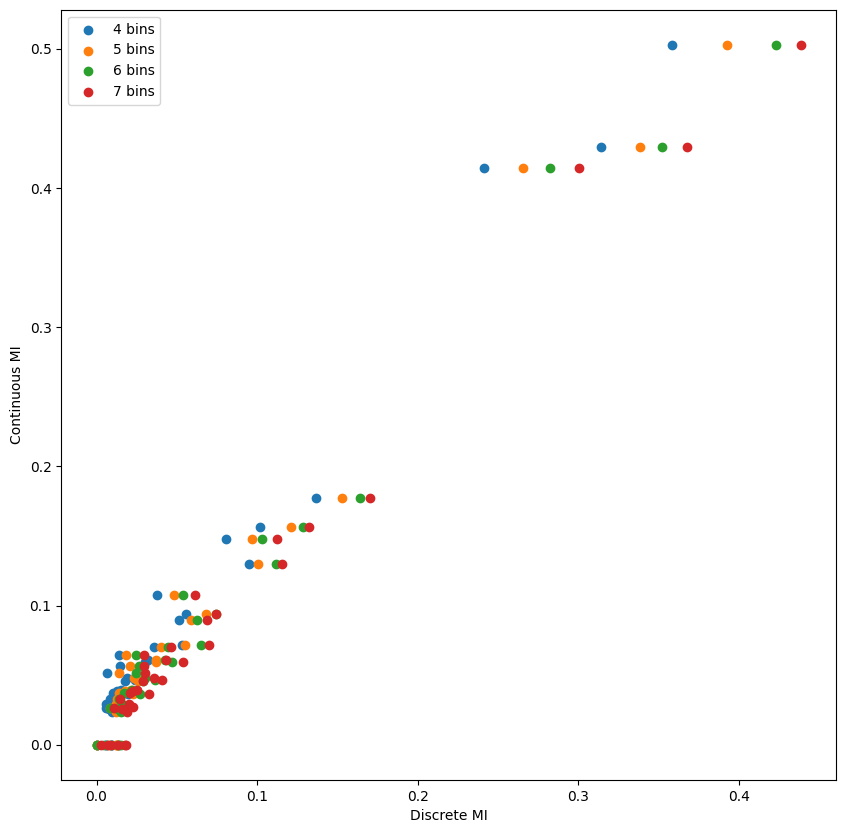

In [8]:
compare_discrete_and_continuous_mi()

## Methodology

In [9]:
def generate_mi_result(assets_pca_discrete, continuous=False):
    return populate_pairwise_adjacency_matrix(assets_pca_discrete, list(assets_pca_discrete.columns), kraskov_jidt.calc_mi_kraskov if continuous else info_theory.MI)

def generate_oinfo_result(assets_pca_discrete, num_assets, continuous = False):
    asset_combos = list(itertools.combinations(assets_pca_discrete.columns, num_assets))
    
    result = {}
    for subset in asset_combos:
        result[subset] = info_theory.surrogate(info_theory.Oinfo, assets_pca_discrete[list(subset)], continuous)
    return format_dict_to_df(result)

def generate_gradient_oinfo_result(assets_pca_discrete, num_assets = 4, continuous = False):
    assets = list(assets_pca_discrete.columns)
    asset_combos = list(itertools.combinations(assets, num_assets))

    oinfo_discrete_num_asset = calculate(generate_oinfo_result, "Oinfo", assets_pca_discrete, num_assets, continuous).to_dict()[0]
    oinfo_discrete_drop_1 = calculate(generate_oinfo_result, "Oinfo", assets_pca_discrete, num_assets - 1, continuous).to_dict()[0]
    
    all_combos = {}
    for asset in assets:
        filtered_asset_combos = [combo for combo in asset_combos if asset in combo]
        for combo in filtered_asset_combos:
            dropped_combo = tuple(item for item in combo if item != asset)
            
            combo = '-'.join(combo)  # Convert tuple to string for DataFrame compatibility
            dropped_combo = '-'.join(dropped_combo)  # Convert tuple to string for DataFrame compatibility

            combo_val = oinfo_discrete_num_asset[combo] - oinfo_discrete_drop_1[dropped_combo]
            all_combos[(asset, combo)] = combo_val

    return format_dict_to_df(all_combos)

def generate_second_gradient_oinfo_result(assets_pca_discrete, num_assets, continuous = False):
    def second_gradient_of_Oinfo(combo, asset1, asset2):
        combo_drop_asset_2 = tuple(item for item in combo if item != asset2)

        grad_oinfo_num_asset = calculate(generate_gradient_oinfo_result, "grad_oinfo", assets_pca_discrete, len(combo), continuous).to_dict()[0]
        grad_oinfo_num_asset = {(key.split("-")[0], tuple(key.split("-")[1:])): value for key, value in grad_oinfo_num_asset.items()}
        grad_oinfo_drop_1 = calculate(generate_gradient_oinfo_result, "grad_oinfo", assets_pca_discrete, len(combo_drop_asset_2), continuous).to_dict()[0]
        grad_oinfo_drop_1 = {(key.split("-")[0], tuple(key.split("-")[1:])): value for key, value in grad_oinfo_drop_1.items()}
        
        return grad_oinfo_num_asset[(asset1, combo)] - grad_oinfo_drop_1[(asset1, combo_drop_asset_2)]
    
    assets = assets_pca_discrete.columns.to_list()
    asset_combos = list(itertools.combinations(assets, num_assets))
    asset_pairs = list(itertools.combinations(assets, 2))

    second_gradient_of_Oinfo_dict = {}
    for asset1, asset2 in asset_pairs:
        filtered_asset_combos = [combo for combo in asset_combos if asset1 in combo and asset2 in combo]
        for combo in filtered_asset_combos:
            second_gradient_of_Oinfo_dict[((asset1, asset2), combo)] = second_gradient_of_Oinfo(combo, asset1, asset2)

    second_gradient_of_Oinfo_dict = pd.Series({"-".join(list(itertools.chain(*key))): value for key, value in second_gradient_of_Oinfo_dict.items()})
    return pd.Series(second_gradient_of_Oinfo_dict)

def generate_oinfo_over_time(assets_pca, window_size_years, rolling_size_years, num_assets, continuous):
    assets = assets_pca.columns.to_list()
    asset_combos = list(itertools.combinations(assets, num_assets))
    dates = get_dates(assets_pca, window_size_years, rolling_size_years)
    oinfo_over_time_df = populate_date_adjacency_matrix(assets_pca, dates, asset_combos, info_theory.Oinfo, window_size_years, continuous)
    return oinfo_over_time_df

def generate_grad_oinfo_over_time(assets_pca_discrete, window_size_years, rolling_size_years, num_asset):
    def gradient_of_Oinfo_over_time(asset_df, combo, window_size_years, rolling_size_years, asset, continuous):
        num_asset = len(combo)

        oinfo_discrete_num_asset = calculate(generate_oinfo_over_time, "t_Oinfo", asset_df, window_size_years, rolling_size_years, num_asset, continuous)
        oinfo_discrete_drop_1 = calculate(generate_oinfo_over_time, "t_Oinfo", asset_df, window_size_years, rolling_size_years, num_asset - 1, continuous)

        dropped_combo = tuple(item for item in combo if item != asset)

        return (oinfo_discrete_num_asset[combo] - oinfo_discrete_drop_1[dropped_combo]).values

    assets = assets_pca_discrete.columns.to_list()
    asset_combos = list(itertools.combinations(assets, num_asset))
    dates = get_dates(assets_pca_discrete, window_size_years, rolling_size_years)

    adj_matrix = pd.DataFrame(index=dates, columns=assets)
    for asset in assets:
        filtered_combos = [combo for combo in asset_combos if asset in combo]
        all_combos_grad_oinfo_asset = [gradient_of_Oinfo_over_time(assets_pca_discrete, combo, window_size_years, rolling_size_years, asset, False) for combo in filtered_combos]
        avg_grad_oinfo_asset = np.mean(all_combos_grad_oinfo_asset, axis=0)
        adj_matrix[asset] = avg_grad_oinfo_asset
    
    return adj_matrix


### Instantaneous Market Dependency Using Mutual Information and O-Information

1. Computing mutual information between all asset pairs

In [10]:
def shift_timeseries(timeseries):
    """
    Randomly circularly shifts a time series to break temporal alignment.
    """
    shift = np.random.randint(-500, 500)
    return np.roll(timeseries, shift)

def MI_significance_test(assets_pca_discrete, significance_level=5, num_surrogates=100):
    """
    Performs a significance test for Mutual Information (MI) between all pairs of assets.

    Parameters:
        assets_pca_discrete (dict): Dictionary mapping asset names to discretized PCA time series.
        significance_level (float): Significance level for the test (default 5%).
        num_surrogates (int): Number of surrogate samples for estimating the null distribution.

    Prints:
        - Whether all MI values are significant or not.
        - Which asset pairs (if any) have insignificant MI values.
    """
    assets = list(assets_pca_discrete.keys())
    asset_pairs = list(itertools.combinations(assets, 2))

    insignificant_pairs = []

    for asset1, asset2 in asset_pairs:
        # Compute observed mutual information
        observed_mi = info_theory.MI(assets_pca_discrete, asset1, asset2)

        # Generate null distribution using surrogate (shifted) time series
        surrogate_mis = []
        for _ in range(num_surrogates):
            ts1 = [x[0] for x in assets_pca_discrete[asset1]]
            ts2 = [x[0] for x in assets_pca_discrete[asset2]]
            surrogate_mi = info_theory.MI_timeseries(shift_timeseries(ts1), shift_timeseries(ts2))
            surrogate_mis.append(surrogate_mi)

        # Determine MI threshold based on surrogate distribution
        threshold = np.percentile(surrogate_mis, 100 - significance_level)

        # If observed MI is below threshold, it's considered insignificant
        if observed_mi < threshold:
            insignificant_pairs.append((asset1, asset2))

    # Report results
    if not insignificant_pairs:
        print(f"All asset pairs have significant MI at the {significance_level}% level.")
    else:
        print(f"Insignificant MI pairs at the {significance_level}% level: {insignificant_pairs}")

In [11]:
MI_significance_test(assets_pca_discrete)

All asset pairs have significant MI at the 5% level.


In [13]:
mi_matrix = calculate(generate_mi_result, info_theory.MI, assets_pca_discrete, False)

def plot_heatmap(df):
    mask = np.eye(len(df), dtype=bool)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="OrRd", mask=mask,
                cbar=True, square=True, linewidths=0.5, linecolor='gray',
                vmin=0, vmax=0.5)  # adjust range if needed
    plt.tight_layout()
    plt.show()
    

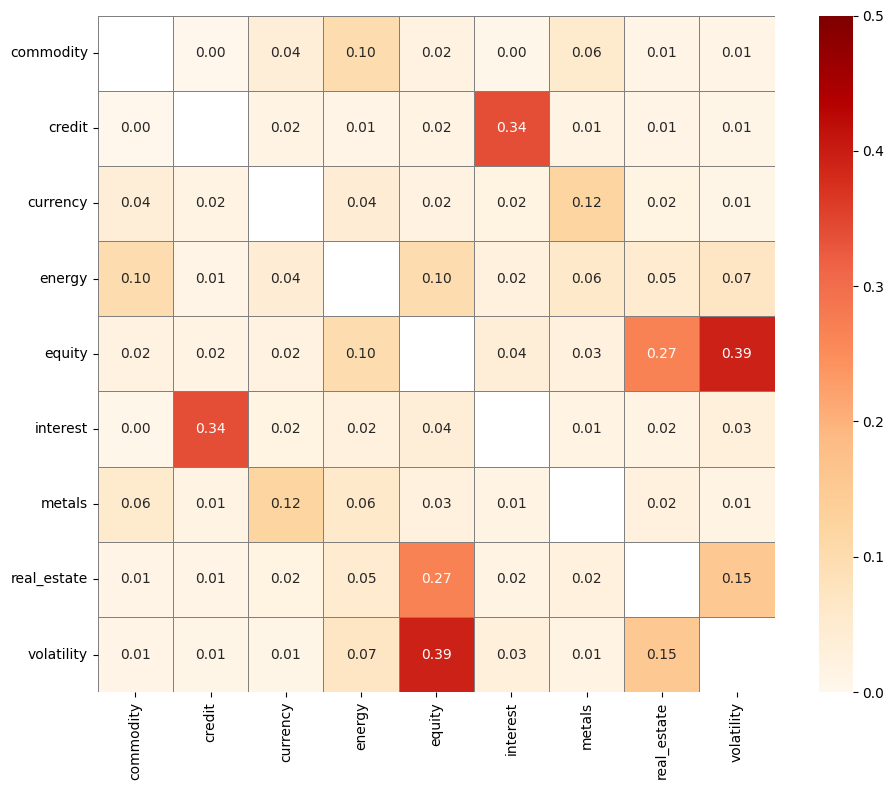

In [14]:
plot_heatmap(mi_matrix)

2. System-wide O-information

In [15]:
print(f"System-wide O-information: {calculate(generate_oinfo_result, info_theory.Oinfo, assets_pca_discrete, len(assets_pca_discrete.columns), False).values[0][0]}")

System-wide O-information: 0.600232528102369


3. Average Mutual Information

In [16]:
plot_assets = ["credit", "interest", "commodity", "currency", "metals", "energy", "real_estate", "volatility", "equity"]
assets = list(assets_pca_discrete.columns)

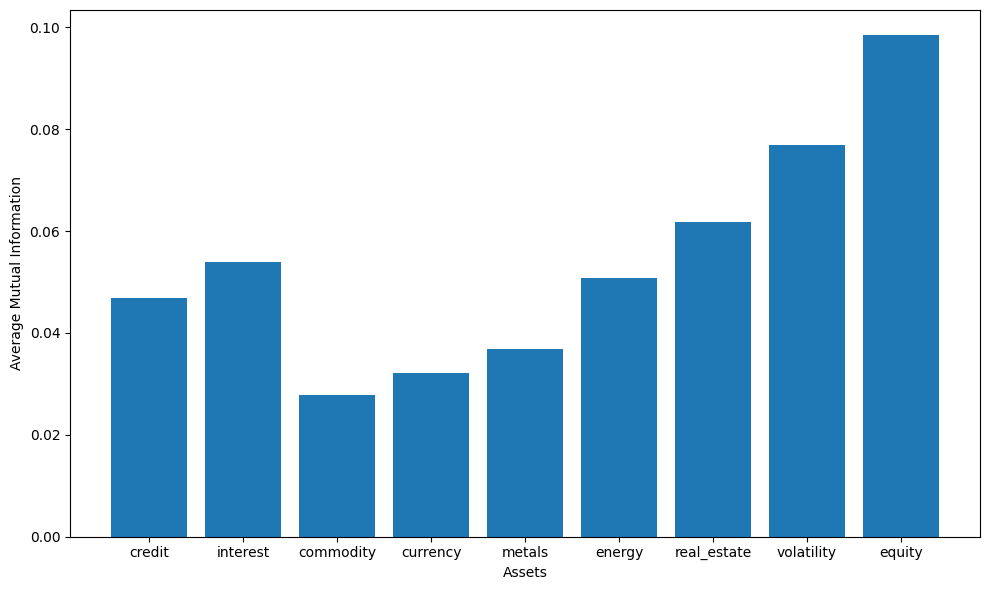

In [17]:
mi_matrix = calculate(generate_mi_result, info_theory.MI, assets_pca_discrete, False)
avg_mi_matrix = mi_matrix.apply(lambda x: np.mean(x))

fig, ax = plt.subplots(figsize=(10, 6))
avg_mi_plot = [avg_mi_matrix[asset] for asset in plot_assets]
plt.bar(plot_assets, avg_mi_plot)
plt.xlabel("Assets")
plt.ylabel("Average Mutual Information")
plt.tight_layout()

4. Average O-information of triplets for each asset

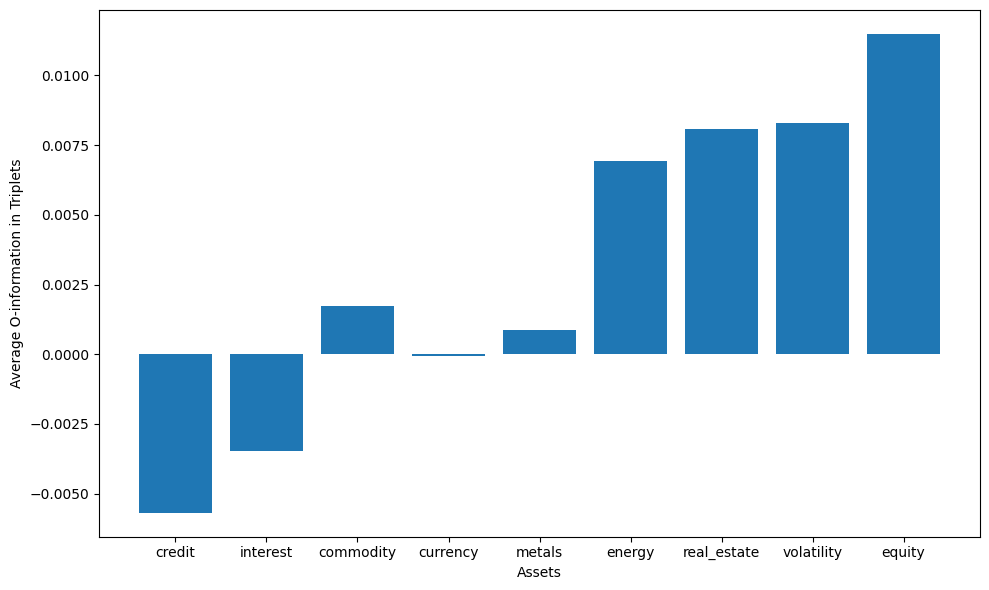

In [18]:
oinfo_discrete = calculate(generate_oinfo_result, info_theory.Oinfo, assets_pca_discrete, 3, False).to_dict()[0]
oinfo_discrete = {(tuple(key.split("-"))): value for key, value in oinfo_discrete.items()}

avg_oinfo = {}
for asset in assets:
    total_oinfo_asset = 0
    filtered_asset_combos = [combo for combo in oinfo_discrete.keys() if asset in combo]
    for combo in filtered_asset_combos:
        total_oinfo_asset += oinfo_discrete[combo]
    avg_oinfo[asset] = total_oinfo_asset / len(filtered_asset_combos)

fig, ax = plt.subplots(figsize=(10, 6))
avg_oinfo_plot = [avg_oinfo[asset] for asset in plot_assets]
plt.bar(plot_assets, avg_oinfo_plot)
plt.xlabel("Assets")
plt.ylabel("Average O-information in Triplets")
plt.tight_layout()

5.  A Breakdown of Credit's O-information

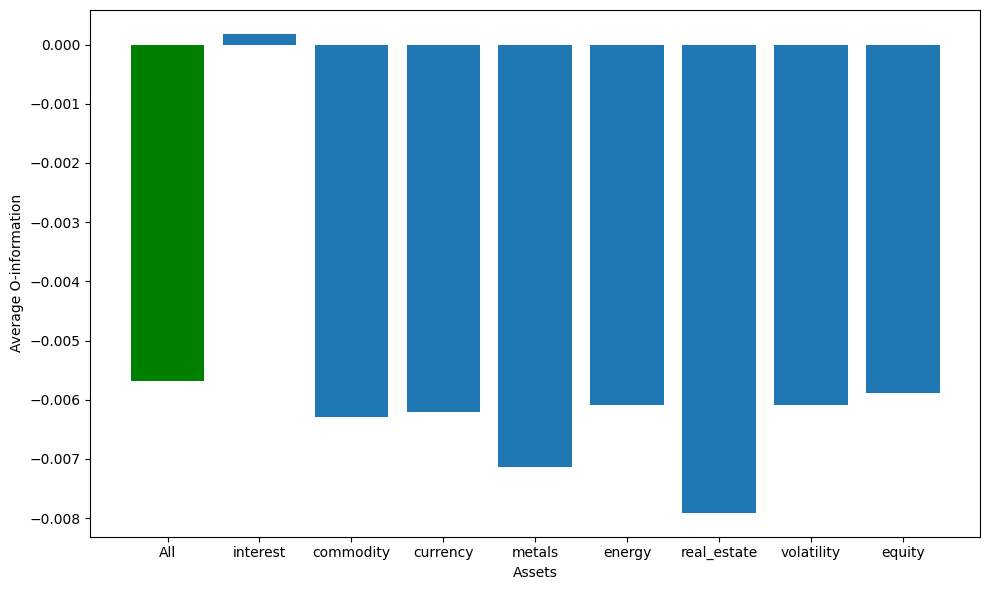

In [19]:
credit_other_asset_dict = {}
for asset in assets:
    filter_credit_asset_oinfo = {key: value for key, value in oinfo_discrete.items() if "credit" in key and asset in key}
    credit_other_asset_dict[asset] = np.mean(list(filter_credit_asset_oinfo.values()))

fig, ax = plt.subplots(figsize=(10, 6))
avg_credit_other_asset = [credit_other_asset_dict[asset] for asset in plot_assets if asset != "credit"]
plt.bar("All", credit_other_asset_dict["credit"], color='green', label='Credit')
plt.bar([asset for asset in plot_assets if asset != "credit"], avg_credit_other_asset)
plt.xlabel("Assets")
plt.ylabel("Average O-information")
plt.tight_layout()

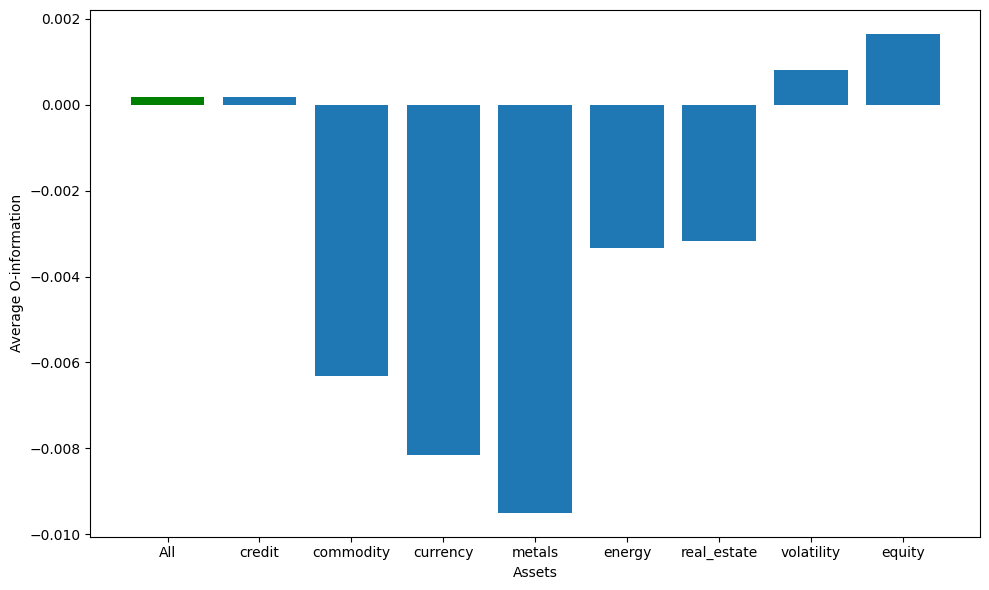

In [20]:
interest_other_asset_dict = {}
for asset in assets:
    filter_interest_asset_oinfo = {key: value for key, value in oinfo_discrete.items() if "interest" in key and asset in key}
    interest_other_asset_dict[asset] = np.mean(list(filter_interest_asset_oinfo.values()))

fig, ax = plt.subplots(figsize=(10, 6))
avg_interest_other_asset = [interest_other_asset_dict[asset] for asset in plot_assets if asset != "interest"]
plt.bar("All", interest_other_asset_dict["credit"], color='green', label='Credit')
plt.bar([asset for asset in plot_assets if asset != "interest"], avg_interest_other_asset)
plt.xlabel("Assets")
plt.ylabel("Average O-information")
plt.tight_layout()

6. Average Gradient of O-information of quadruplets for each asset

In [21]:
num_assets = 4

grad_oinfo_result = calculate(generate_gradient_oinfo_result, "grad_oinfo", assets_pca_discrete, num_assets, False).to_dict()[0]
grad_oinfo_result = {(key.split("-")[0], tuple(key.split("-")[1:])): value for key, value in grad_oinfo_result.items()}

gradient_oinfo_dict = {}

for asset in assets:
    filtered_grad_oinfo = [v for k, v in grad_oinfo_result.items() if asset == k[0]]
    avg_grad_oinfo_asset = np.mean(filtered_grad_oinfo)
    gradient_oinfo_dict[asset] = avg_grad_oinfo_asset

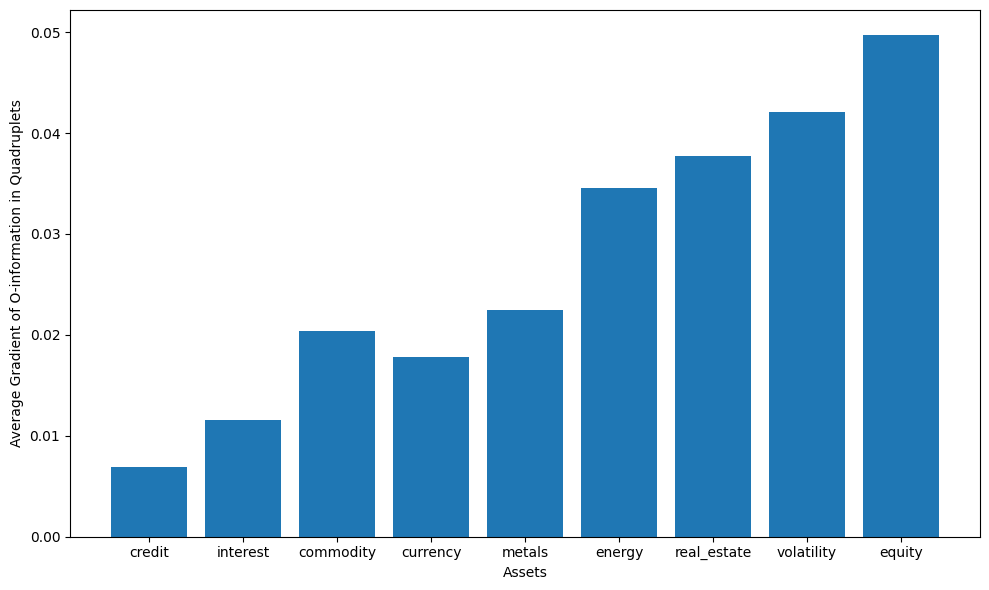

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
avg_grad_oinfo_plot = [gradient_oinfo_dict[asset] for asset in plot_assets]
plt.bar(plot_assets, avg_grad_oinfo_plot)
plt.xlabel("Assets")
plt.ylabel("Average Gradient of O-information in Quadruplets")
plt.tight_layout()

## Temporal Evolution of O-information over Time

1. System-wide O-information Over Time

Text(0, 0.5, 'O-Information Value')

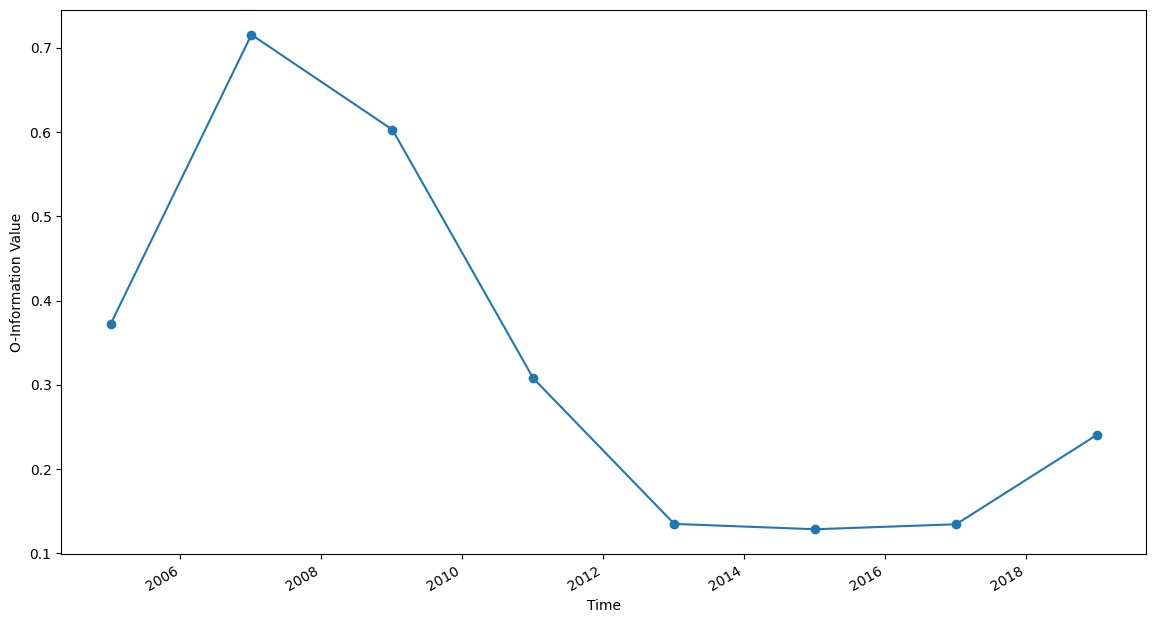

In [23]:
window_size_years = 6
rolling_size_years = 3
num_assets = 3

assets = list(assets_pca_discrete.columns)
asset_combos = list(itertools.combinations(assets, num_assets))

oinfo_over_time_df = calculate(generate_oinfo_over_time, "t_Oinfo", assets_pca_discrete, window_size_years, rolling_size_years, 9, False)

fig, ax = plt.subplots(figsize=(14, 8))  # Bigger figure
oinfo_over_time_df.plot(ax = ax, marker = "o")
ax.legend().remove()
ax.set_xlabel("Time")
ax.set_ylabel("O-Information Value")

2. Average O-information of Triplets per asset over Time

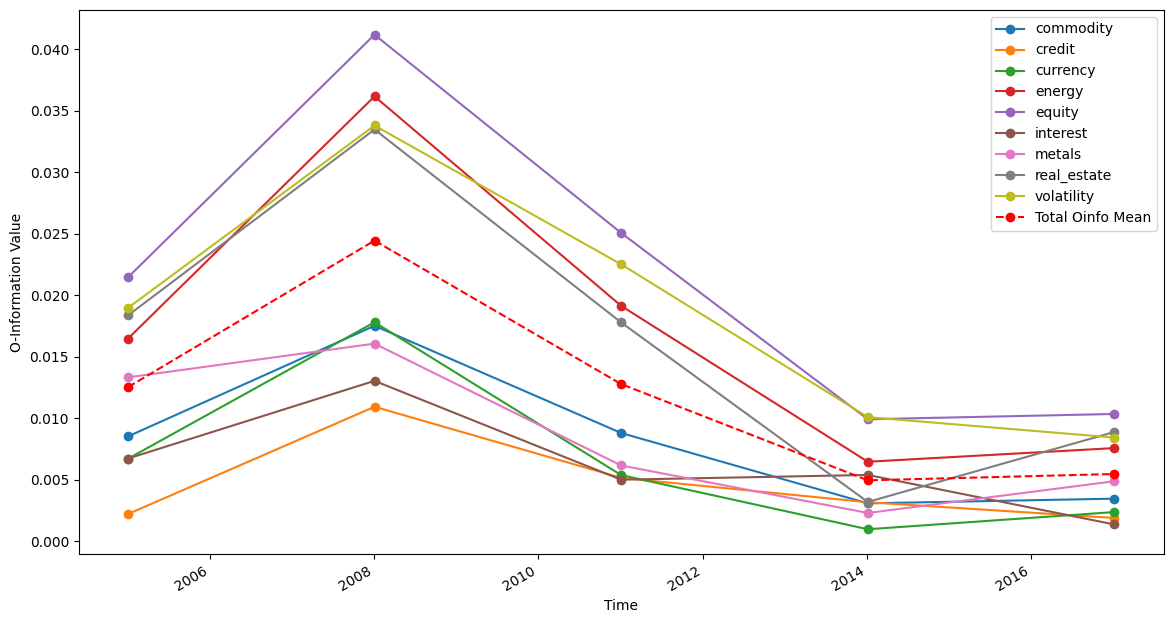

In [24]:
num_assets = 3
window_size_years = 6
rolling_size_years = 3
continuous = False

oinfo_over_time_df = calculate(generate_oinfo_over_time, "t_Oinfo", assets_pca_discrete, window_size_years, rolling_size_years, num_assets, continuous)

fig, ax = plt.subplots(figsize=(14, 8))  # Bigger figure
avg_asset_oinfo_over_time_df = pd.DataFrame(index=oinfo_over_time_df.index, columns=assets)
for asset in assets:
    filtered_columns = [combo for combo in oinfo_over_time_df.columns if asset in combo]
    avg_asset_oinfo_over_time_df[asset] = np.mean(oinfo_over_time_df[filtered_columns], axis = 1)

avg_asset_oinfo_over_time_df.plot(ax=ax, marker='o')

total_oinfo_over_time_mean = np.mean(oinfo_over_time_df, axis=1)
total_oinfo_over_time_mean.plot(ax=ax, marker='o', color='red', linestyle='--', label='Total Oinfo Mean')
ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("O-Information Value")

plt.show()

3. Average Gradient of O-information of Quadruplets per asset over Time

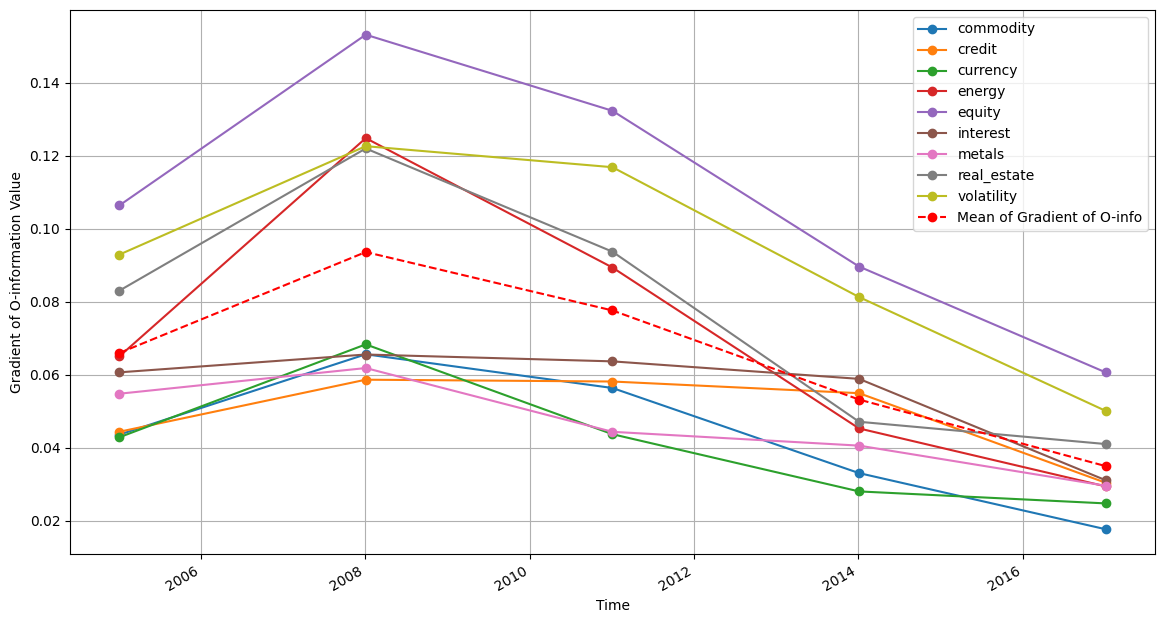

In [25]:
num_asset = 4
window_size_years = 6
rolling_size_years = 3

grad_oinfo_matrix = calculate(generate_grad_oinfo_over_time, "t_grad_oinfo", assets_pca_discrete, window_size_years, rolling_size_years, num_asset)

fig, ax = plt.subplots(figsize=(14, 8))
grad_oinfo_matrix.plot(ax = ax, marker = "o")

adj_mean = np.mean(grad_oinfo_matrix, axis=1)
adj_mean.plot(ax=ax, marker='o', color='red', linestyle='--', label='Mean of Gradient of O-info')

plt.xlabel("Time")
plt.ylabel("Gradient of O-information Value")
plt.grid(True)
plt.legend()

### Relationship Between Pairwise Metrics and O-Information

1. Average Pearson Correlation Coefficient against O-information of Triplets and Quadruplets

In [26]:
assets = assets_pca_discrete.columns.to_list()
corr_dict = {}
for asset1 in assets:
    for asset2 in assets:
        if asset1 != asset2:
            corr = np.abs(asset_pca_cont[asset1].corr(asset_pca_cont[asset2]))
            corr_dict[(asset1, asset2)] = corr
            corr_dict[(asset2, asset1)] = corr

corr_df = pd.DataFrame(index=assets, columns=assets)
for key, value in corr_dict.items():
    corr_df.loc[key[0], key[1]] = value

In [27]:
oinfo_discrete = calculate(generate_oinfo_result, info_theory.Oinfo, assets_pca_discrete, 4, False).to_dict()[0]
oinfo_discrete = {(tuple(key.split("-"))): value for key, value in oinfo_discrete.items()}

oinfo_discrete_3 = calculate(generate_oinfo_result, info_theory.Oinfo, assets_pca_discrete, 3, False).to_dict()[0]
oinfo_discrete_3 = {(tuple(key.split("-"))): value for key, value in oinfo_discrete_3.items()}

oinfo_discrete.update(oinfo_discrete_3)

In [28]:
def average_abs_linear_correlation(combo):
    pairs = list(itertools.combinations(combo, 2))
    avg_corr = 0
    for pair in pairs:
        avg_corr += corr_df.loc[pair[0], pair[1]]
    return avg_corr / len(pairs)

oinfo_correlation = [(v, average_abs_linear_correlation(k)) for k, v in oinfo_discrete.items()]

In [29]:
from scipy.stats import linregress

# Separate synergistic and redundant values
syn_corrs = [(v, corr) for (v, corr) in oinfo_correlation if v < 0]
red_corrs = [(v, corr) for (v, corr) in oinfo_correlation if v > 0]

# Linear regression for synergistic region
syn_x = [v for v, _ in syn_corrs]
syn_y = [corr for _, corr in syn_corrs]
syn_slope, syn_intercept, syn_r_value, syn_p_value, syn_se = linregress(syn_x, syn_y)

# Linear regression for redundant region
red_x = [v for v, _ in red_corrs]
red_y = [corr for _, corr in red_corrs]
red_slope, red_intercept, red_r_value, red_p_value, red_se = linregress(red_x, red_y)

# One-line summaries
print(f"Synergistic: slope={syn_slope}, R²={syn_r_value**2}, p={syn_p_value}, SE={syn_se}")
print(f"Redundant: slope={red_slope}, R²={red_r_value**2}, p={red_p_value}, SE={red_se}")


Synergistic: slope=-1.837356199282433, R²=0.02503803710608755, p=0.3427057926501351, SE=1.9108905184279072
Redundant: slope=1.25334601653973, R²=0.3578719952464899, p=1.1121594425426916e-13, SE=0.1501629967363228


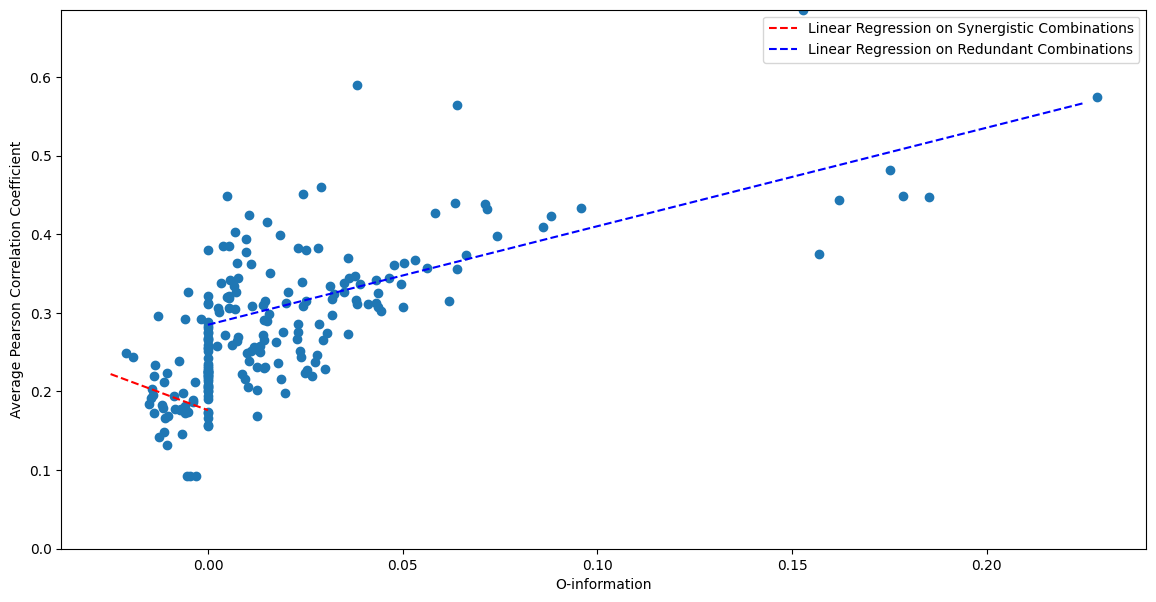

In [30]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_xlabel("O-information")
ax.set_ylabel("Average Pearson Correlation Coefficient")
ax.set_ylim(0, max(syn_y + red_y))

ax.plot(np.arange(-0.025, 0.01, 0.0125), syn_slope * np.arange(-0.025, 0.01, 0.0125) + syn_intercept, color = "red", linestyle = "--", label = "Linear Regression on Synergistic Combinations")
ax.plot(np.arange(0, 0.25, 0.025), red_slope * np.arange(0, 0.25, 0.025) + red_intercept, color = "blue", linestyle = "--", label = "Linear Regression on Redundant Combinations")
ax.legend()

ax.scatter([v[0] for v in oinfo_correlation], [v[1] for v in oinfo_correlation])

2. Computing Second-order Gradient of O-information Heatmap

In [31]:
second_grad_oinfo_dict = calculate(generate_second_gradient_oinfo_result, "sec_grad_oinfo", assets_pca_discrete, 5, False).to_dict()[0]
second_grad_oinfo_dict = {(tuple(key.split("-")[:2]), tuple(key.split("-")[2:])): value for key, value in second_grad_oinfo_dict.items()}

In [32]:
# Separate data in terms of (a, b) pairs
grouped_data = {}
for key, value in second_grad_oinfo_dict.items():
    pair = key[0]  # Extract (a, b) from the key
    if pair not in grouped_data:
        grouped_data[pair] = []
    grouped_data[pair].append(value)

# Compute averages for each (a, b)
averaged_data = {pair: sum(values) / len(values) for pair, values in grouped_data.items()}

# Step 2: Build adjacency matrix
# Extract unique row and column indices
rows = sorted(set(a for a, _ in averaged_data.keys()))

# Initialize the adjacency matrix with zeros
second_grad_adj_matrix = pd.DataFrame(0, index=rows, columns=rows)

# Populate the matrix with averaged values
for (a, b), avg_value in averaged_data.items():
    second_grad_adj_matrix.loc[a, b] = avg_value
    second_grad_adj_matrix.loc[b, a] = avg_value  

second_grad_adj_matrix = second_grad_adj_matrix.fillna(0)

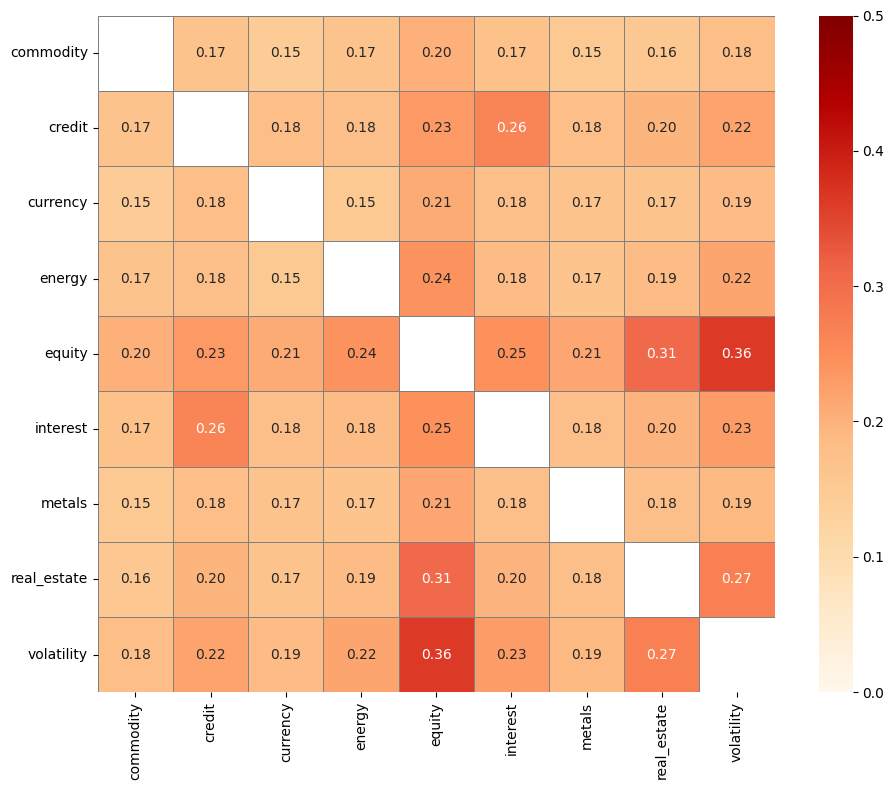

In [33]:
plot_heatmap(second_grad_adj_matrix)

3. Calculating the Top 10% (90th percentile) of Mutual Information and Second-order Gradient of O-information

In [34]:
mi_matrix = calculate(generate_mi_result, kraskov_jidt.calc_mi_kraskov if continuous else info_theory.MI, assets_pca_discrete, continuous)

In [35]:
# Redundant pairs
def print_pairs(df):
    non_redundant_pairs = df.where(pd.notna(df)).where(~pd.isna(df)).where(
        ~pd.DataFrame(np.tril(np.ones(df.shape), k=0).astype(bool), 
                    index=df.index, columns=df.columns)
    ).stack()

    # Print results
    for (row, col), value in non_redundant_pairs.items():
        print(f"{row} - {col}: {value:.6f}")


print(f"Second Gradient of Oinfo (90th percentile):")
second_top_pairs = second_grad_adj_matrix[second_grad_adj_matrix > np.percentile(second_grad_adj_matrix.values.flatten(), 90)]
print_pairs(second_top_pairs)

print(f"\nMutual Information (90th percentile):")
mi_top_pairs = mi_matrix[mi_matrix > np.percentile(mi_matrix.values.flatten(), 90)]
print_pairs(mi_top_pairs)

Second Gradient of Oinfo (90th percentile):
credit - interest: 0.264177
equity - real_estate: 0.305835
equity - volatility: 0.362298
real_estate - volatility: 0.271367

Mutual Information (90th percentile):
credit - interest: 0.339625
equity - real_estate: 0.267072
equity - volatility: 0.393659
real_estate - volatility: 0.154338


4. Calculating the Bottom 10% (10th percentile) of Mutual Information and Second-order Gradient of O-information

In [36]:
# Synergistic pairs

print(f"Second Gradient of Oinfo (10th percentile):")
second_bottom_pairs = second_grad_adj_matrix[second_grad_adj_matrix <= np.percentile([i for i in second_grad_adj_matrix.values.flatten() if i != 0], 10)]
print_pairs(second_bottom_pairs)

print(f"\nMutual Information (10th percentile):")
mi_bottom_pairs = mi_matrix[mi_matrix <= np.percentile([i for i in mi_matrix.values.flatten() if i != 0], 10)]
print_pairs(mi_bottom_pairs)

Second Gradient of Oinfo (10th percentile):
commodity - currency: 0.146626
commodity - metals: 0.153512
commodity - real_estate: 0.157697
currency - energy: 0.153936

Mutual Information (10th percentile):
commodity - credit: 0.000000
commodity - interest: 0.004699
commodity - volatility: 0.012827
credit - volatility: 0.008221
currency - volatility: 0.009819
